# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

In [12]:
%%capture
import sys

# For Google reproducibility
if 'google.colab' in sys.modules:
    DATA_PATH = "/content/drive/My Drive/Kaggle"
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

    #Connect to remote data
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    %cd DATA_PATH

# Local data store on drive D:
else:
    DATA_PATH = "D:/Datafiles/"

In [13]:
# Import Block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#xgboost
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost') 
#dataviz
#from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
#sklearn
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance


Part One - Dataset Basics

For this week's modules I am using the asteroid dataset found on Kaggle here: https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset
(This is a cleaner version of the NASA/JPL datasets used in my portfolio projects, as such thoroughness is not needed for the daily projects)

The target for this exercise will be the Potentially Hazardous Asteroid classification feature. 
Unfortunately (or, fortunately for the Earth) this feature is heavily unbalanced in favor of 'no' so we will need to adjust our metrics.

This is an unbalanced binary classification problem, so we will evaluate balanced accuracy and F1 score, as well as ROC AUC.
We will also evaluate the accuracy of the models trained on synthetically balanced datasets using eg. SMOTE techniques.

The features in this dataset have a lot of redundancy due to having been merged from various sources; additionally there are
many label features which need to be culled for modeling purposes and to prevent cross-leaking. 

Also worthy of note is that the PHA designation is a direct fuction of two features, absolute magnitude ('H') and minimum orbit intercept 
distance ('moid'), so models will eventually be compared between the initial inference with the features included, and ones built without 
those features.

In [14]:
# Wrangling Functions

def wrangle(filepath):

    df = pd.read_csv(filepath, index_col=['pdes']) #pdes = primary designation number
    
    #drop extraneous label/index/constant columns
    labels = ['id', 'spkid', 'full_name', 'name', 'prefix', 'orbit_id', 'equinox', 'class']
    df.drop(columns=labels, inplace=True)
    #drop duplicate date/distance columns
    #NOTE: we want consistent Julian dates & AU distances
    labels= ['epoch_mjd', 'epoch_cal', 'tp_cal', 'per_y', 'moid_ld']
    df.drop(columns=labels, inplace=True)
    #drop leaky columns
    labels = ['neo']
    df.drop(columns=labels, inplace=True)

    #drop rows with no target value
    df.dropna(subset=['pha'], inplace=True)

    #convert pha to tidy numeric binary encoding
    df['pha'] = [1 if flag=='Y' else 0 for flag in df['pha']]

    #calculate missing albedo from magnitude
    abdmask =  (df['albedo'].isna() & ~(df['H'].isna() | df['diameter'].isna()))
    df['albedo'].where(~abdmask, ((1329*(10**((-1)*(df['H']/5)))/df['diameter'])**2), inplace=True) 

    # impute remaining missing albedo with standard value
    # see: https://en.wikipedia.org/wiki/Standard_asteroid_physical_characteristics
    df['albedo'].where(~(df['albedo'].isna()), other=0.1, inplace=True)

    # calculate missing diameter values from magnitude
    diamask = (df['diameter'].isna() & ~(df['H'].isna() | df['albedo'].isna()))
    df['diameter'].where(~diamask, (1329/(np.sqrt(df['albedo'])))*(10**((-1)*(df['H']/5))), inplace=True)

    #impute missing diameter sigma values
    #replacing with maximum error as we are using derived diameter values
    df['diameter_sigma'].where(~(df['diameter_sigma'].isna()), other=df['diameter_sigma'].max(), inplace=True)

    #finally, calculate missing magnitude values from albedo and diameter
    hmask = (df['H'].isna() & ~(df['albedo'].isna() | df['diameter'].isna()))
    df['H'].where(~hmask, 5 * (np.log10((1329/(df['diameter'] * np.sqrt(df['albedo']))))), inplace=True)

    #any remaining missing values must be dropped
    df.dropna(inplace=True)

    return df

In [15]:
df = wrangle(DATA_PATH + "/Asteroids/dataset.csv")

print(df.shape)
print("")
print(df.info())

Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.


(936499, 30)

<class 'pandas.core.frame.DataFrame'>
Index: 936499 entries, 1 to 2678 T-3
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   pha             936499 non-null  int64  
 1   H               936499 non-null  float64
 2   diameter        936499 non-null  float64
 3   albedo          936499 non-null  float64
 4   diameter_sigma  936499 non-null  float64
 5   epoch           936499 non-null  float64
 6   e               936499 non-null  float64
 7   a               936499 non-null  float64
 8   q               936499 non-null  float64
 9   i               936499 non-null  float64
 10  om              936499 non-null  float64
 11  w               936499 non-null  float64
 12  ma              936499 non-null  float64
 13  ad              936499 non-null  float64
 14  n               936499 non-null  float64
 15  tp              936499 non-null  float64
 16  per             936499 non-null  float64
 17 

Part Two - Baseline Modeling

Baseline accuracy of ~0.998 is a bit problematic, so we will try 
1. Different scoring methods
2. Some basic resampling 
before building the initial models

In [16]:
# Create two datasets to model, with/without the H (magnitude) + moid columns
# easy mode = default columns, hard mode = without, model must infer from other data
df_hard = df.drop(columns=['H', 'moid'])

X = df.drop(columns='pha')
y = df['pha']

X_h = df_hard.drop(columns='pha')
y_h = df_hard['pha']

#naive baseline scores
model_dum = DummyClassifier(strategy='prior').fit(X, y)
dum_pred = model_dum.predict(X)
baseline_acc = accuracy_score(y, dum_pred)
print(baseline_acc)
base_bal_acc = balanced_accuracy_score(y, dum_pred)
print(base_bal_acc)


0.9977939111520674
0.5


In [17]:
#split datasets into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_h_train, X_h_test, y_h_train, y_h_test = train_test_split(X_h, y_h, test_size=0.2, random_state=42)

#get majority/minority class splits for resampling
class_mask = (df['pha'] == 1)
X_train_min, X_train_maj = X_train.loc[class_mask], X_train.loc[~class_mask]
X_h_train_min, X_h_train_maj = X_h_train.loc[class_mask], X_h_train.loc[~class_mask]

#evenly over- and under-sample dataset to create balanced training set
pha_y, pha_n = y_train.value_counts(sort=True, ascending=True)

train_midp_sample_1 = X_train_min.sample(((pha_n + pha_y)//2), replace=True)
y_sample_1 = pd.Series([1] * len(train_midp_sample_1))
train_midp_sample_0 = X_train_maj.sample(((pha_n + pha_y)//2)+1, replace=False)
y_sample_0 = pd.Series([0] * len(train_midp_sample_0))
X_train_res =  train_midp_sample_1.append(train_midp_sample_0, ignore_index=True)
y_train_res = pd.concat([y_sample_1, y_sample_0], ignore_index=True)

pha_h_y, pha_h_n = y_h_train.value_counts(sort=True, ascending=True)

train_h_midp_sample_1 = X_h_train_min.sample(((pha_n + pha_y)//2), replace=True)
y_h_sample_1 = pd.Series([1] * len(train_h_midp_sample_1))
train_h_midp_sample_0 = X_h_train_maj.sample(((pha_h_n + pha_h_y)//2)+1, replace=False)
y_h_sample_0 = pd.Series([0] * len(train_h_midp_sample_0))
X_h_train_res =  train_h_midp_sample_1.append(train_h_midp_sample_0, ignore_index=True)
y_h_train_res = pd.concat([y_h_sample_1, y_h_sample_0], ignore_index=True)

#check for deformed arrays
print(X_train.shape)
print(X_train_res.shape)
print(y_train.shape)
print(y_train_res.shape)

print(X_h_train.shape)
print(X_h_train_res.shape)
print(y_h_train.shape)
print(y_h_train_res.shape)


(749199, 29)
(749199, 29)
(749199,)
(749199,)
(749199, 27)
(749199, 27)
(749199,)
(749199,)


In [18]:
# Initial models
# No need for Imputer or Encoder transformers
model_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
model_rf = make_pipeline(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))

print("######### Original Dataset Distributions ########")

print("*Full Data Columns*")

model_lr.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Accuracy: ", lr_acc)
lr_acc_bal = balanced_accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Balanced Accuracy: ", lr_acc_bal)

model_rf.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Accuracy: ", rf_acc)
rf_acc_bal = balanced_accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Balanced Accuracy: ", rf_acc_bal)

print("*Limited Data Columns*")

model_lr.fit(X_h_train, y_h_train)
lr_h_acc = accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Accuracy: ", lr_h_acc)
lr_h_acc_bal = balanced_accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Balanced Accuracy: ", lr_h_acc_bal)

model_rf.fit(X_h_train, y_h_train)
rf_h_acc = accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Accuracy: ", rf_h_acc)
rf_h_acc_bal = balanced_accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Balanced Accuracy: ", rf_h_acc_bal)

print("######### Resampled Dataset Distributions ########")

print("*Full Data Columns*")

model_lr.fit(X_train_res, y_train_res)
lr_acc = accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Accuracy: ", lr_acc)
lr_acc_bal = balanced_accuracy_score(y_test, model_lr.predict(X_test))
print("LR Model Balanced Accuracy: ", lr_acc_bal)

model_rf.fit(X_train_res, y_train_res)
rf_acc = accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Accuracy: ", rf_acc)
rf_acc_bal = balanced_accuracy_score(y_test, model_rf.predict(X_test))
print("RF Model Balanced Accuracy: ", rf_acc_bal)

print("*Limited Data Columns*")

model_lr.fit(X_h_train_res, y_h_train_res)
lr_h_acc = accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Accuracy: ", lr_h_acc)
lr_h_acc_bal = balanced_accuracy_score(y_h_test, model_lr.predict(X_h_test))
print("LR Model Balanced Accuracy: ", lr_h_acc_bal)

model_rf.fit(X_h_train_res, y_h_train_res)
rf_h_acc = accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Accuracy: ", rf_h_acc)
rf_h_acc_bal = balanced_accuracy_score(y_h_test, model_rf.predict(X_h_test))
print("RF Model Balanced Accuracy: ", rf_h_acc_bal)


######### Original Dataset Distributions ########
*Full Data Columns*
LR Model Accuracy:  0.9982594767752269
LR Model Balanced Accuracy:  0.6768255810981356
RF Model Accuracy:  0.999893219434063
RF Model Balanced Accuracy:  0.9828633334716426
*Limited Data Columns*
LR Model Accuracy:  0.9974319273892152
LR Model Balanced Accuracy:  0.524940230108523
RF Model Accuracy:  0.9983342231713828
RF Model Balanced Accuracy:  0.6985016999579061
######### Resampled Dataset Distributions ########
*Full Data Columns*
LR Model Accuracy:  0.9938280832888414
LR Model Balanced Accuracy:  0.9969068082328135
RF Model Accuracy:  0.9999092365189536
RF Model Balanced Accuracy:  0.9942601281858235
*Limited Data Columns*
LR Model Accuracy:  0.979183128670582
LR Model Balanced Accuracy:  0.9895671672143078
RF Model Accuracy:  0.9978323545114789
RF Model Balanced Accuracy:  0.874776072142512


Part Three - Permutation Importances and Gradient Boosting

From the last part two things are clear:
1. The additional H and moid data columns dramatically affect the power of the model, 
    to the point they could be considered 'leaky'.
2. Resampling to balance the dataset greatly improves the fit of the final model.

So for this next part we are going to focus on just the limited (_h) and resampled datasets
and try to improve the models based on them.

In [19]:
#reconstruct the models for part 3 and get their feature importances

model_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
model_rf = make_pipeline(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))

model_lr.fit(X_h_train_res, y_h_train_res)
model_rf.fit(X_h_train_res, y_h_train_res)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

Text(0.5, 0, 'coefficient')

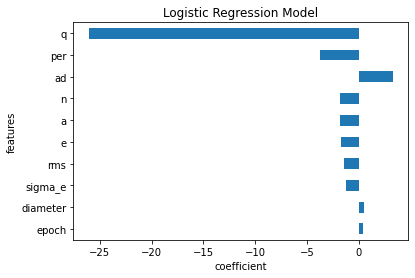

In [20]:
lr_imp = model_lr.named_steps['logisticregression'].coef_[0]
pd.Series(data=lr_imp, index=X_h.columns).sort_values(key=abs).tail(10).plot(kind='barh')
plt.title('Logistic Regression Model')
plt.ylabel('features')
plt.xlabel('coefficient')


Text(0.5, 0, 'importance')

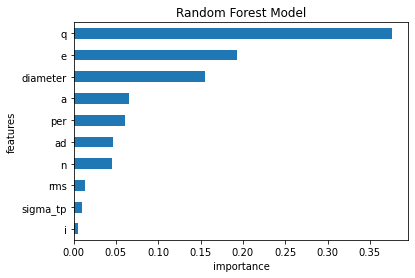

In [21]:
rf_imp = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=rf_imp, index=X_h.columns).sort_values(key=abs).tail(10).plot(kind='barh')
plt.title('Random Forest Model')
plt.ylabel('features')
plt.xlabel('importance')

Looking at the above plots, both models prioritize q (perihelion distance) as well as a collection of other features.
It's worth noting the tree-based model is more balanced in its features while the LR model includes some questionable
coefficients (_sigma columns represent error values) that may not actually be contributing.

In [22]:
# Split testing values into validation and testing sets for permutation tuning
X_h_val_p, X_h_test_p, y_h_val_p, y_h_test_p = train_test_split(X_h_test, y_h_test, train_size=0.5, random_state=42)

#generate permutation importance arrays
lr_imp_p = permutation_importance(model_lr, X_h_val_p, y_h_val_p, scoring='balanced_accuracy', n_jobs=-1, random_state=42)
rf_imp_p = permutation_importance(model_rf, X_h_val_p, y_h_val_p, scoring='balanced_accuracy', n_jobs=-1, random_state=42)

data_lr_p = {'imp_mean':lr_imp_p['importances_mean'], 'imp_std':lr_imp_p['importances_std']}
df_lr_p = pd.DataFrame(data_lr_p, index=X_h_val_p.columns, columns=data_lr_p)
data_rf_p = {'imp_mean':rf_imp_p['importances_mean'], 'imp_std':lr_imp_p['importances_std']}
df_rf_p = pd.DataFrame(data_rf_p, index=X_h_val_p.columns, columns=data_rf_p)

Text(0.5, 0, 'perm. importance')

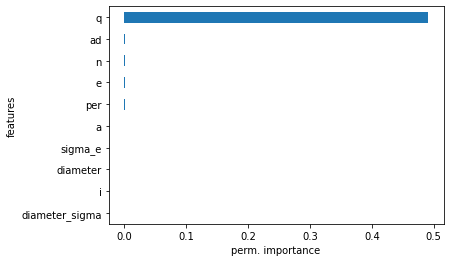

In [23]:
df_lr_p['imp_mean'].sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('perm. importance')

Text(0.5, 0, 'perm. importance')

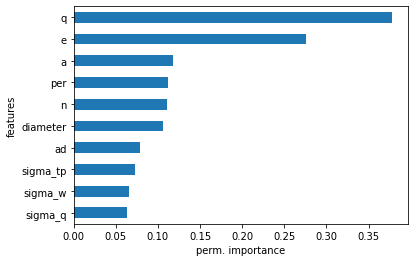

In [24]:
df_rf_p['imp_mean'].sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('perm. importance')

This confirms something is likely going wrong in the Logistic Regression model, so we 
are going to drop it going forward.
Now, onto the least relevant data columns in the remaining model:

Text(0.5, 0, 'perm. importance')

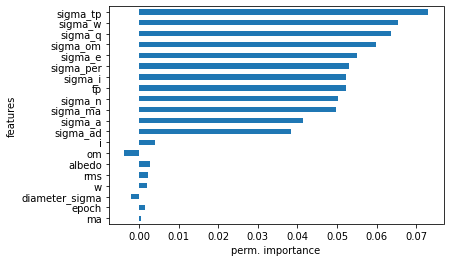

In [25]:
df_rf_p['imp_mean'].sort_values(key=abs).head(20).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('perm. importance')

From the above we can see that it should be possible to drop some columns to reduce noise.
We can 1. Drop columns below a certain importance threshold and 2. Drop columns whose
corresponding error columns (sigma) are ranked with higher importance (ie the noise 
in the data is being ranked as more important than the data, so both are probably irrelevant)

In [51]:
#create final train, val, test sets by dropping noise columns

noise_cols = ['diameter_sigma', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 
              'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per',
              'tp', 'rms', 'i', 'w', 'albedo', 'om', 'epoch', 'ma']

X_train_final = X_h_train_res.drop(columns=noise_cols)
X_val_final = X_h_val_p.drop(columns=noise_cols)
X_test_final = X_h_test_p.drop(columns=noise_cols)
y_train_final, y_val_final, y_test_final = y_h_train_res, y_h_val_p, y_h_test_p

In [52]:
# Build a new Gradient Boosted model using the improved dataset

#setup for hyperparam tuning
tun_params = {"n_estimators": np.arange(50, 100, 10),
                "max_depth": np.arange(3, 16, 1),
                "min_child_weight": np.arange(1, 10, 2),
                "learning_rate": np.arange(0.05, 0.40, 0.05)}
y_tun_final = y_train_final.append(y_val_final)
X_tun_final = X_train_final.append(X_val_final)
tunerset = [-1 if x < len(X_train_final) else 0 for x in range(0, len(X_tun_final))]
tuner = PredefinedSplit(tunerset)

#fit new xgb model to new dataset
xgb_inst = XGBClassifier(random_state=42) #no further pipeline needed
model_xgb = RandomizedSearchCV(xgb_inst, tun_params, cv=tuner, n_iter=10, scoring='balanced_accuracy', 
                                n_jobs=-1, random_state=42, verbose=1)
model_xgb.fit(X_tun_final, y_tun_final)

#display tuned hyperparameters and new model accuracy
print("Tuned params: ", model_xgb.best_params_)
print("Best Tuning Score: ", model_xgb.best_score_)
print("Test Balanced Accuracy: ", balanced_accuracy_score(y_test_final, model_xgb.predict(X_test_final)))
#bring back old score for comparison
print("Previous best RF model score: ", rf_h_acc_bal)


Fitting 1 folds for each of 10 candidates, totalling 10 fits
Tuned params:  {'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1}
Best Tuning Score:  0.9974850171232876
Test Balanced Accuracy:  0.9952754939198738
Previous best RF model score:  0.8644860449112228


In [53]:
# Build the same model on the old dataset for comparison

y_tun_ = y_h_train_res.append(y_h_val_p)
X_tun_ = X_h_train_res.append(X_h_val_p)
tunerset_ = [-1 if x < len(X_h_train_res) else 0 for x in range(0, len(X_tun_))]
tuner_ = PredefinedSplit(tunerset)

xgb_inst_ = XGBClassifier(random_state=42) #no further pipeline needed
model_xgb_ = RandomizedSearchCV(xgb_inst_, tun_params, cv=tuner_, n_iter=10, scoring='balanced_accuracy', 
                                n_jobs=-1, random_state=42, verbose=1)
model_xgb_.fit(X_tun_, y_tun_)

#display tuned hyperparameters and new model accuracy
print("Tuned params (unpruned dataset): ", model_xgb_.best_params_)
print("Best Balanced Accuracy Score (unpruned dataset): ", model_xgb_.best_score_)
print("Test Balanced Accuracy: ", balanced_accuracy_score(y_h_test_p, model_xgb_.predict(X_h_test_p)))
#bring back old score for comparison
print("Previous best RF model score: ", rf_h_acc_bal)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Tuned params (unpruned dataset):  {'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1}
Best Balanced Accuracy Score (unpruned dataset):  0.9978381849315068
Test Balanced Accuracy:  0.9977467834129006
Previous best RF model score:  0.8644860449112228


Comparing the two models it looks like we are losing some accuracy but roughly halving the processing time
Let's try one more time with a dataset that just drops the least significant sigma columns and the zero-influence data

In [26]:
#new compromise set of columns
noise_cols = ['diameter_sigma', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 
              'sigma_w', 'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per',
              'om', 'ma', 'i']

X_train_final = X_h_train_res.drop(columns=noise_cols)
X_val_final = X_h_val_p.drop(columns=noise_cols)
X_test_final = X_h_test_p.drop(columns=noise_cols)
y_train_final, y_val_final, y_test_final = y_h_train_res, y_h_val_p, y_h_test_p

In [55]:
#build new final version of model

tun_params = {"n_estimators": np.arange(50, 100, 10),
                "max_depth": np.arange(3, 16, 1),
                "min_child_weight": np.arange(1, 10, 2),
                "learning_rate": np.arange(0.05, 0.40, 0.05)}
y_tun_final = y_train_final.append(y_val_final)
X_tun_final = X_train_final.append(X_val_final)
tunerset = [-1 if x < len(X_train_final) else 0 for x in range(0, len(X_tun_final))]
tuner = PredefinedSplit(tunerset)

#fit new xgb model to new dataset
xgb_inst = XGBClassifier(random_state=42) #no further pipeline needed
model_xgb = RandomizedSearchCV(xgb_inst, tun_params, cv=tuner, n_iter=10, scoring='balanced_accuracy', 
                                n_jobs=-1, random_state=42, verbose=1)
model_xgb.fit(X_tun_final, y_tun_final)

#display tuned hyperparameters and new model accuracy
print("Tuned params: ", model_xgb.best_params_)
print("Best Tuning Score: ", model_xgb.best_score_)
print("Test Balanced Accuracy: ", balanced_accuracy_score(y_test_final, model_xgb.predict(X_test_final)))
#bring back old score for comparison
print("Previous best RF model score: ", rf_h_acc_bal)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Tuned params:  {'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1}
Best Tuning Score:  0.9978167808219178
Test Balanced Accuracy:  0.9977681916465073
Previous best RF model score:  0.8644860449112228


In [56]:
#final model test metrics
print("Accuracy Score: ", accuracy_score(y_test_final, model_xgb.predict(X_test_final)))
print("Balanced Accuracy Score: ", balanced_accuracy_score(y_test_final, model_xgb.predict(X_test_final)))
print("F1 Score: ", f1_score(y_test_final, model_xgb.predict(X_test_final)))
print("Fbeta Score (beta = 100): ", fbeta_score(y_test_final, model_xgb.predict(X_test_final), beta=100))
print("ROC Score: ", roc_auc_score(y_test_final, model_xgb.predict(X_test_final)))


Accuracy Score:  0.9955472504004271
Balanced Accuracy Score:  0.9977681916465073
F1 Score:  0.5223367697594501
Fbeta Score (beta = 100):  0.9998171569884835
ROC Score:  0.9977681916465073


In [27]:
#rebuild models for part 4 if necessary

try: model_xgb_
except NameError:
    model_xgb_ = XGBClassifier(n_estimators=50, min_child_weight=3, max_depth=3, learning_rate=0.1,
                                n_jobs=-1, random_state=42).fit(X_train_res, y_h_train_res)
try: model_xgb
except NameError:
    model_xgb = XGBClassifier(n_estimators=50, min_child_weight=3, max_depth=3, learning_rate=0.1,
                                n_jobs=-1, random_state=42).fit(X_train_final, y_train_final)

Part 4 - Data Visualization

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc0cb6f3ed0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc0de439550>})

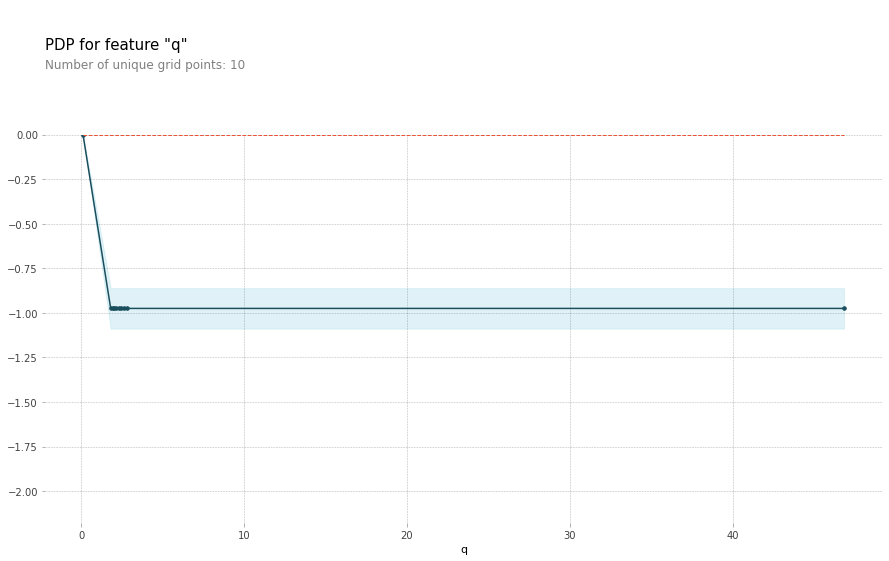

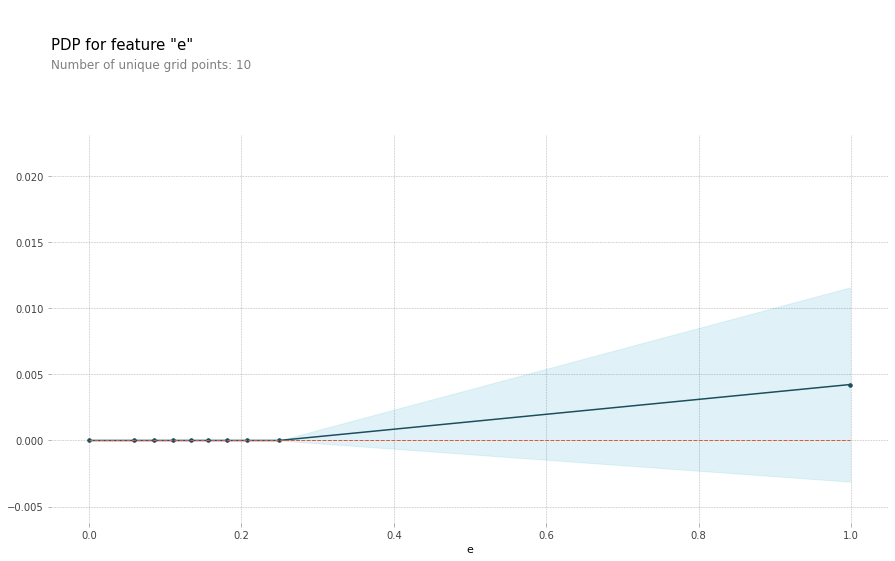

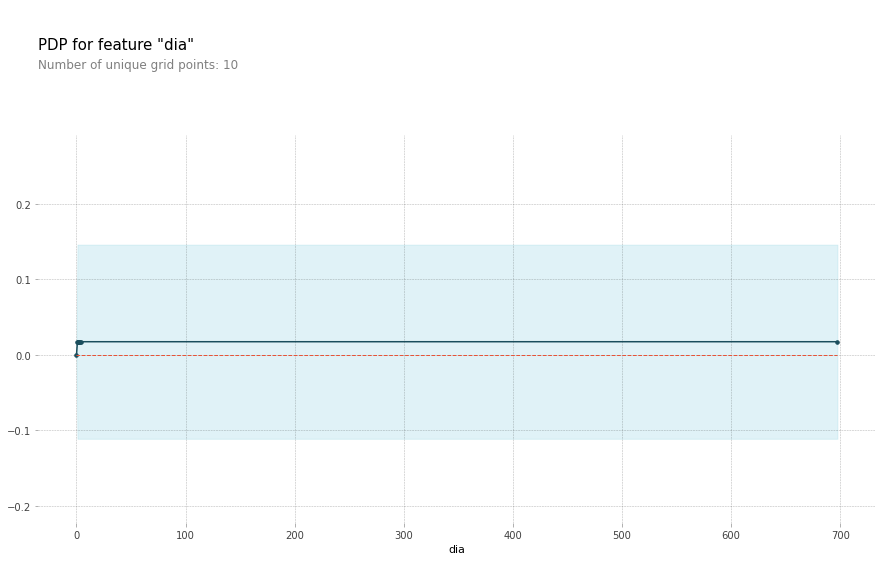

In [58]:
#get the pdp isolate for our major features

#orbit perihelion distance
iso_q = pdp_isolate(model_xgb, dataset=X_train_final, model_features=X_train_final.columns, feature='q')
#orbit eccentricity
iso_e = pdp_isolate(model_xgb, dataset=X_train_final, model_features=X_train_final.columns, feature='e')
#asteroid diameter
iso_dia = pdp_isolate(model_xgb, dataset=X_train_final, model_features=X_train_final.columns, feature='diameter')

#plot individual pdps

pdp_plot(iso_q, feature_name='q')

pdp_plot(iso_e, feature_name='e')

pdp_plot(iso_dia, feature_name='dia')

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc0d1145b90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc0d1196dd0>})

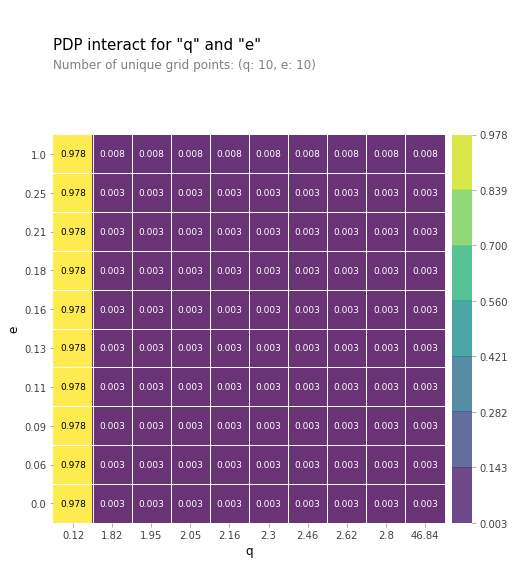

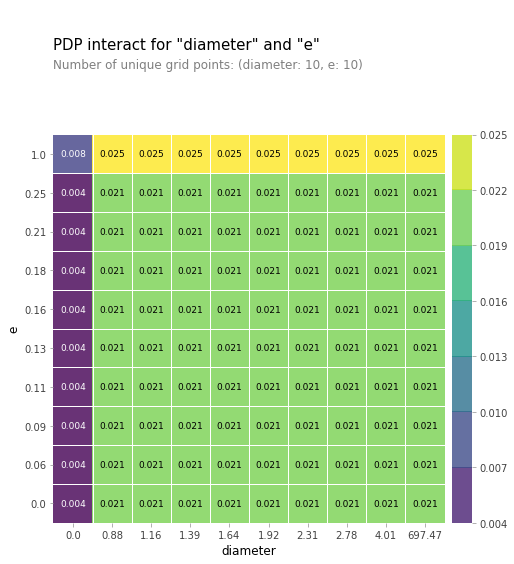

In [59]:
#create feature intereaction plot of perihelion and eccentricity

int_q_e = pdp_interact(model_xgb, dataset=X_val_final, model_features=X_val_final.columns, features=['q', 'e'])

pdp_interact_plot(int_q_e, plot_type='grid', feature_names=['q', 'e'])

#create plot of period and eccentricity

int_dia_e = pdp_interact(model_xgb, dataset=X_val_final, model_features=X_val_final.columns, features=['diameter', 'e'])

pdp_interact_plot(int_dia_e, plot_type='grid', feature_names=['diameter', 'e'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


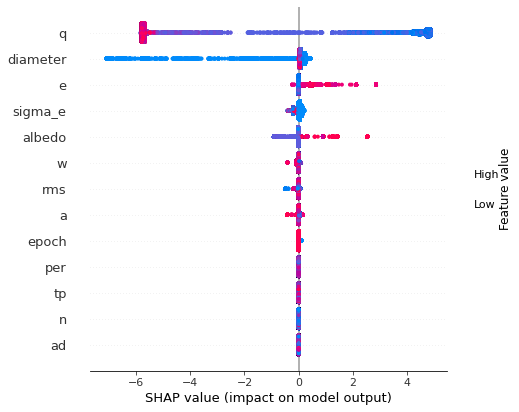

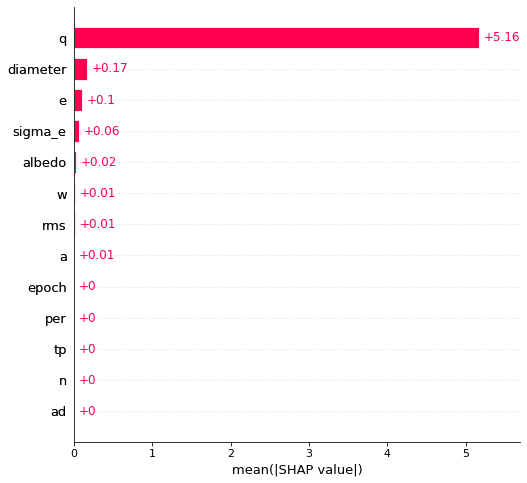

In [28]:
#create shapley plots of the overall tree model

if isinstance(model_xgb, RandomizedSearchCV):
  model_handle = model_xgb.best_estimator_
else: model_handle = model_xgb  

tree_explain = shap.TreeExplainer(model_handle)
shap_tree = tree_explain(X_train_final)

#start javascript module
shap.initjs()

shap.plots.beeswarm(shap_values=shap_tree, max_display=20)

shap.plots.bar(shap_values=shap_tree, max_display=20)


In [36]:
# create shapley force plots for each confusion matrix grid

#generate TP, FP, TN, FN vectors
y_pred = model_handle.predict(X_test_final)

mask_tp = ((y_test_final == 1) & (y_pred == 1))
mask_fp = ((y_test_final == 0) & (y_pred == 1))
mask_tn = ((y_test_final == 0) & (y_pred == 0))
mask_fn = ((y_test_final == 1) & (y_pred == 0))

#create explainers for each masked subset
shap_cm = tree_explain(X_test_final.loc[mask_tp])

# #(re)start javascript module
# shap.initjs()

#finalize each plot
shap.plots.force(shap_cm)

Empty DataFrame
Columns: [diameter, albedo, epoch, e, a, q, w, ad, n, tp, per, sigma_e, rms]
Index: []
(93003, 13)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [37]:
shap_cm = tree_explain(X_test_final.loc[mask_fp])
shap.plots.force(shap_cm)

In [ ]:
###Only run this cell if you have 32+ GB of free RAM!###
# shap_cm = tree_explain(X_test_final.loc[mask_tn])
# shap.plots.force(shap_cm)

In [40]:
print(X_test_final.loc[mask_fn].head()) #there are no false negatives in the test set!

# shap_cm = tree_explain(X_test_final.loc[mask_fn])
# shap.plots.force(shap_cm)

Empty DataFrame
Columns: [diameter, albedo, epoch, e, a, q, w, ad, n, tp, per, sigma_e, rms]
Index: []
